In [ ]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Supervised Machine Learning - 

In the last notebook (Notebook2), we compared various classifiers against the time series data and found four classifiers which yielded efficient results. In this notebook, we focuss on tuning the hyperparameters of top three classifiers. 

* Support Vector Machines
* Random Forest
* K-Nearest Neighbours

<br>
### Methodology - 
* __Base Case__ - We first test the classifier with default settings
* __Data Standardization__ - Tha data is standardized with zero mean and unit variance
* __PCA Transformation__ - The data undergoes PCA transformation to reduce the dimensionality.
* __Optimizing over hyper-parameters using Gridsearch__ - For each classifier, we perform training with grid search and cross validation over a range of parameters. Overfitting is checked by comparing the training scores with cross validation scores.  
* __Comparisons__ - Finally, we compare the results of optimized classifier with base case. 



In [276]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pylab as P
import time, glob, os, math
from matplotlib import cm 
from CommonFunctions import *

from sklearn.decomposition import PCA, FastICA
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

#Classifiers
from sklearn.tree import DecisionTreeClassifier as DT, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV



import matplotlib as mpl
import matplotlib.lines as mlines
mpl.rc('lines', linewidth=2, color='r')
mpl.rc('font', size=16)
mpl.rc('axes', labelsize=16, grid=True)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('legend', fontsize=14)


import warnings
warnings.filterwarnings("ignore")



In [270]:
random_state = 100

In [271]:
os.chdir('/localdata2/bkhamesra3/MachineLearning/GW-MLClassification/Data/')


## Building Data

Collect all waveforms and spin-type. Convert the spin-type category from string to numerical labels. 

In [272]:
#Loading the Dataset

waveform_collection = []
GT_filepaths = sorted(glob.glob("FilteredData/GT*.txt"))
SXS_filepaths = sorted(glob.glob("FilteredData/SXS*.txt"))


for wf_file_gt in GT_filepaths:
    
    metadata_file = os.path.join('Metadata','Metadata_'+os.path.basename(wf_file_gt).split('.txt')[0]+'.csv')
    wf = waveform(wf_file_gt, metadata_file)
    waveform_collection.append(wf)
    
for wf_file_sxs in SXS_filepaths:
    
    metadata_file = os.path.join('Metadata','Metadata_'+os.path.basename(wf_file_sxs).split('.txt')[0]+'.csv')
    wf = waveform(wf_file_sxs, metadata_file)
    waveform_collection.append(wf)
    


In [273]:
#Concatenate plus and cross polarization
def concat_wf_timedata(wf):
    '''Concatenate the real and imaginary components of waveform in time domain'''
    #print(wf.name, wf.spin_type)
    data = np.concatenate((wf.hp, wf.hx))
    
    return data

def concat_wf_freqdata(wf):
    '''Concatenate the plus and cross polarization components of waveform in frequency domain'''
    #print(wf.name, wf.spin_type)
    data = np.concatenate((np.absolute(wf.hf_plus)[wf.freq>0], np.absolute(wf.hf_cross)[wf.freq>0]))
    
    return data


waveform_collection  = np.asarray(waveform_collection)

waveform_nospin  = []
waveform_alignspin  = []
waveform_precess  = []

#print(le.inverse_transform(y))
for wf in waveform_collection:
    if wf.spin_type=='Precessing':
        waveform_precess.append(wf)
    elif wf.spin_type=='NonSpinning':
        waveform_nospin.append(wf)
    else: 
        waveform_alignspin.append(wf)

        
wf_precess_select50 =  np.random.choice(waveform_precess, size=50, replace=False)

wf_collection_short = np.asarray(waveform_nospin + waveform_alignspin + list(wf_precess_select50))


# waveform_data_ht - each row represents concatenated data corresponding to one waveform in order (t, real, imag)
waveform_data_ht = list(map(concat_wf_timedata, wf_collection_short))
waveform_data_ht = np.matrix(waveform_data_ht)

# waveform_data_hf - each row represents concatenated data corresponding to one waveform in order (f, FT(real), FT(imag))
waveform_data_hf = list(map(concat_wf_freqdata, wf_collection_short))
waveform_data_hf = np.matrix(waveform_data_hf)

# Output
y = [wf.spin_type for wf in wf_collection_short]

# Convert spin labels from string to numbers
le = preprocessing.LabelEncoder()
y_numeric = le.fit_transform(y)



In [275]:
#Distribution of the data

cls_uniq = np.unique(y_numeric)
npts_clas0 = np.size(np.where(y_numeric==cls_uniq[0]))
npts_clas1 = np.size(np.where(y_numeric==cls_uniq[1]))
npts_clas2 = np.size(np.where(y_numeric==cls_uniq[2]))

cls_uniq = le.inverse_transform(cls_uniq)
print('Total number of points = %d'%np.size(y_numeric))
print('Total {} cases = {}'.format(cls_uniq[0], npts_clas0))
print('Total {} cases = {}'.format(cls_uniq[1], npts_clas1))
print('Total {} cases = {}'.format(cls_uniq[2], npts_clas2))

Total number of points = 151
Total AlignedSpins cases = 55
Total NonSpinning cases = 46
Total Precessing cases = 50


##  Logistic Regression  Optimization

Let's first test our method by optimizing logistic regression. We can start with the default parameters with 2 PCA components and training size of 0.85 (based on previous analysis). 


__Optimization Methods__ - 
1. PCA Variation - Variations in PCA components from 2 to 40
2. Grid Search - Variations over tolerance (sets the stopping criteria), regularization strength, class weight and solver. 


__Results__-

1. Base Case - For the default classifier (non-optimized), we see the CV scores lie close to 40-50% while test scores are extremely low but improve with number of PCA components. 
2. Optimized Classifier - Results improve significantly with Training, Test and CV scores reaching upto 60-70%. The classifier now attempts to distinguish between all three classes even with just 2 PCA components
3. Primary modifications which improved the results include using balanced weight with higher regularization strength (or smaller values of 'C').
4. Even with improved results, Logistic Regression is clearly not a good method as accuracies are extremely low. This is simply due to inherent non-linear nature of the data which can be clearly gauged from distribution of data in the decision surface plots. 

In [277]:
# Logisitic Regression - Default Classifier Results as a function of PCA components


#Finding optimal training data size    
pca_num  = np.array((2,5,10,20,30,40))
trainsize=0.8
rs = random_state

#Split data into training and testing
data = np.copy(waveform_data_ht)
y    = np.copy(y_numeric)
data_train, data_test, y_train, y_test = train_test_split(data, y, train_size=trainsize, test_size=1-trainsize, random_state=rs)

#Standardize the data before applying PCA
SS_data = StandardScaler()
data_train =  SS_data.fit_transform(data_train)
data_test = SS_data.transform(data_test)

print("Training Data after standardization - Mean = {:.4g}, Standard Deviation = {:.4g}".format(data_train.mean(), data_train.std()))
print("Test Data after standardization - Mean = {:.4g}, Standard Deviation = {:.4g} \n\n".format(data_test.mean(), data_test.std()))

print("# PCA Comp    # Classes Predicted \t Train score \t CV score \t Test Score ")
print("-"*100)

score_train, score_test, cv_scores = np.zeros((3, len(pca_num)))

#plt.figure(figsize=(10,6))
for i, pca_comp in enumerate(pca_num):
    
    #Apply PCA
    pca = PCA(svd_solver='full', n_components=pca_comp, random_state=random_state)
    data_train_pca = pca.fit_transform(data_train)
    data_test_pca= pca.transform(data_test)
    pca_time = time.time() 
    
    
    #Logistic Regression with default parameters
    clf = LogisticRegression( max_iter=1000, random_state=rs)  
    clf.fit(data_train_pca, y_train)
    
    #Compute the cross validation, training and test scores
    score_train[i] = clf.score(data_train_pca, y_train)
    cv_scores[i] = cross_val_score(clf, data_train_pca, y_train, cv=5).mean()
    score_test[i] = clf.score(data_test_pca,y_test)
    clf_class_predictions = np.unique(clf.predict(data_test_pca))
    
    
    print(" %d \t \t \t %d \t\t %.2g \t\t %.2g \t\t %.2g"%(pca_comp, np.size(np.unique(clf_class_predictions)), score_train[i], \
                                             cv_scores[i], score_test[i]))
    #print("Classes predicted using {} PCA components by Logistic regression = {}".format(pca_comp, le.inverse_transform(clf_class_predictions)))
    #print("Logistic Regression with default settings and 2 PCA components - ")
    #print("\t Training Score = {:.4g}".format(score_train))
    #print("\t CV Score       = {:.4g}".format(cv_scores.mean()))
    #print("\t Test Score = {:.4g}".format(score_test))
    
    
lr_rawscores_dict = {'pca':pca_num, 'train_score':score_train, 'cv_score': cv_scores, 'test_score':score_test}


Training Data after standardization - Mean = 2.233e-18, Standard Deviation = 1
Test Data after standardization - Mean = -0.00308, Standard Deviation = 1.024 


# PCA Comp    # Classes Predicted 	 Train score 	 CV score 	 Test Score 
----------------------------------------------------------------------------------------------------
 2 	 	 	 2 		 0.38 		 0.34 		 0.23
 5 	 	 	 3 		 0.47 		 0.42 		 0.23
 10 	 	 	 3 		 0.53 		 0.43 		 0.23
 20 	 	 	 3 		 0.57 		 0.38 		 0.32
 30 	 	 	 3 		 0.63 		 0.42 		 0.39
 40 	 	 	 3 		 0.76 		 0.47 		 0.42


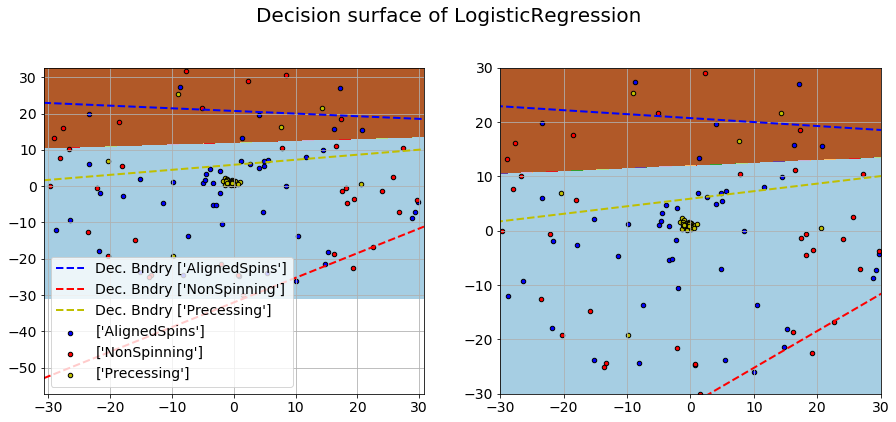

In [8]:
#Plot decision Surface

#Train classifier - 
data_train_pca, pca_train_time = func_PCA(2, data_train, rs)
pca_time = time.time() 


#Logistic Regression with default parameters
clf = LogisticRegression( max_iter=1000, random_state=rs)  
clf.fit(data_train_pca, y_train)
    

# Create a mesh to plot in
h = .1# step size in the mesh
x_min, x_max = data_train_pca[:, 0].min() - 1, data_train_pca[:, 0].max() + 1
y_min, y_max = data_train_pca[:, 1].min() - 1, data_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

fig =  plt.figure(figsize=(15,6))

plt.subplot(121)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
#plt.axis('tight')
         
plt.subplot(122)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
fig.suptitle("Decision surface of LogisticRegression", fontsize=20, y=1.02 )
plt.axis('tight')


# Plot also the training points
colors = "bry"
for i, color in zip(clf.classes_, colors):
    idx = np.where(y_train == i)
    plt.subplot(121)
    plt.scatter(data_train_pca[idx, 0], data_train_pca[idx, 1], c=color, cmap=plt.cm.Paired,\
                edgecolor='black', s=20, label=le.inverse_transform(np.asarray([i])))
    
    
    plt.subplot(122)
    plt.scatter(data_train_pca[idx, 0], data_train_pca[idx, 1], c=color, cmap=plt.cm.Paired,\
                edgecolor='black', s=20, label=le.inverse_transform(np.asarray([i])))
   
# Plot the three one-against-all classifiers
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
coef = clf.coef_
intercept = clf.intercept_

def plot_hyperplane(c, color):
    def line(x0):
        return (-(x0 * coef[c, 0]) - intercept[c]) / coef[c, 1]
    plt.plot([xmin, xmax], [line(xmin), line(xmax)],
             ls="--", color=color, label='Dec. Bndry %s'%le.inverse_transform(np.asarray([c])))

for i, color in zip(clf.classes_, colors):
    plt.subplot(121)
    plot_hyperplane(i, color)
    plt.legend()
    
    plt.subplot(122)
    plot_hyperplane(i, color)
    #plt.legend()
    
plt.xlim(-30,30)
plt.ylim(-30,30)

plt.show()

In [9]:
#Logistic Regression Optimization with gridsearch and PCA components


clf = LogisticRegression(penalty='l2', max_iter=1000, random_state=rs)  
params={'C':10.**np.arange(-3,1,1),'solver':['newton-cg', 'lbfgs','sag', 'saga'], 'tol':[1e-1, 1e-2,1e-3,1e-4], 'class_weight':[None, 'balanced']}
verbose=1 

#Finding optimal training data size    
pca_num  = np.array((2,5,10,20))
trainsize=0.8
rs = random_state


data = np.copy(waveform_data_ht)
y    = np.copy(y_numeric)
data_train, data_test, y_train, y_test = train_test_split(data, y, train_size=trainsize, test_size=1-trainsize, random_state=rs)

#Standardize the data before applying PCA
SS_data = StandardScaler()
data_train =  SS_data.fit_transform(data_train)
data_test = SS_data.transform(data_test)


score_train, score_test, cv_scores = np.zeros((3, len(pca_num)))

#standardization_time = time.time() 
for i, pca_comp in enumerate(pca_num):

    #Apply PCA
    pca = PCA(svd_solver='full', n_components=pca_comp, random_state=random_state)
    data_train_pca = pca.fit_transform(data_train)
    data_test_pca= pca.transform(data_test)
    
    pca_time = time.time() 
    
    #Perform a grid search over given parameters
    param_grid=params 
    nprocs=-1
    search = GridSearchCV(clf, param_grid, cv=5, n_jobs=nprocs)
    
    #Compute the cross validation, training and test scores
    search.fit(data_train_pca, y_train)
    score_train[i] = search.score(data_train_pca, y_train)
    cv_scores[i] = cross_val_score(search, data_train_pca, y_train, cv=5).mean()
    score_test[i] = search.score(data_test_pca,y_test)
    #print(score_train[i], cv_scores[i], score_test[i])
    if pca_comp==2:
        grid_params = search.best_params_
        
    print("Number of PCA components = {}, LR best parameters = {}".format(pca_comp, search.best_params_))

lr_optscores_dict = {'pca':pca_num, 'train_score':score_train, 'cv_score': cv_scores, 'test_score':score_test}

    



Number of PCA components = 2, LR best parameters = {'C': 0.01, 'class_weight': 'balanced', 'solver': 'sag', 'tol': 0.1}
Number of PCA components = 5, LR best parameters = {'C': 0.001, 'class_weight': None, 'solver': 'newton-cg', 'tol': 0.1}
Number of PCA components = 10, LR best parameters = {'C': 0.01, 'class_weight': 'balanced', 'solver': 'saga', 'tol': 0.01}
Number of PCA components = 20, LR best parameters = {'C': 1.0, 'class_weight': None, 'solver': 'saga', 'tol': 0.01}


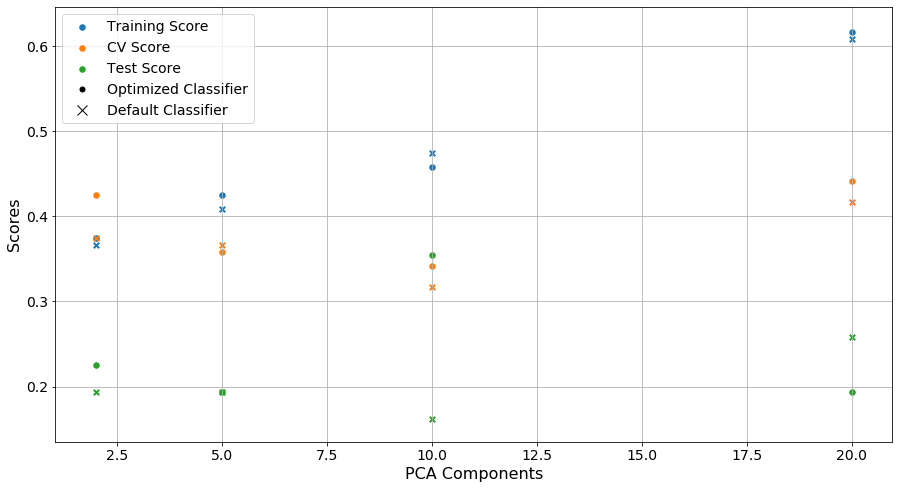

In [10]:
#Plots
plt.figure(figsize=(15,8))

train_plot = plt.scatter(lr_optscores_dict['pca'], lr_optscores_dict['train_score'], marker='o',  s=30, c='C0', label='Training Score')
cv_plot    = plt.scatter(lr_optscores_dict['pca'], lr_optscores_dict['cv_score'], marker='o',  s=30, c='C1', label='CV Score')
test_plot  =plt.scatter(lr_optscores_dict ['pca'], lr_optscores_dict['test_score'], marker='o', s=30, c='C2', label='Test Score')

plt.scatter(lr_rawscores_dict['pca'], lr_rawscores_dict['train_score'], marker='x', s=30, c='C0')
plt.scatter(lr_rawscores_dict['pca'], lr_rawscores_dict['cv_score'], marker='x', s=30, c='C1')
plt.scatter(lr_rawscores_dict['pca'], lr_rawscores_dict['test_score'], marker='x', s=30, c='C2')

opt_params = mlines.Line2D([], [], color='k', marker='.', linestyle='None',
                          markersize=10, label='Optimized Classifier')
def_params = mlines.Line2D([], [], color='k', marker='x', linestyle='None',
                          markersize=10, label='Default Classifier')

plt.xlabel('PCA Components')
plt.ylabel('Scores')
plt.legend(handles = [train_plot, cv_plot, test_plot, opt_params, def_params])
plt.show()
plt.close()
   

Logistic Regression with default settings and 2 PCA components - 
	 Training Score = 0.375
	 CV Score       = 0.45
	 Test Score = 0.1613


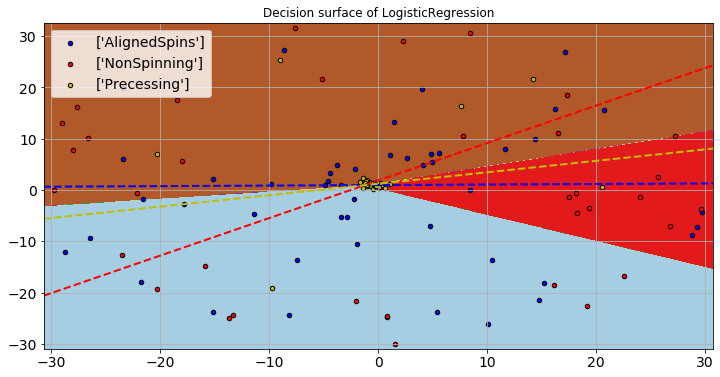

In [11]:
#Decision boundaries for Logistic Regression with optimized parameters ( 2 PCA components)

clf_lr = LogisticRegression( max_iter=1000, C=grid_params['C'], class_weight=grid_params['class_weight'], solver=grid_params['solver'],tol=grid_params['tol'], random_state=random_state)  

#Finding optimal training data size    
pca_num  = 2
trainsize=0.8
rs = random_state

#Split data into training and testing
data = np.copy(waveform_data_ht)
y    = np.copy(y_numeric)
data_train, data_test, y_train, y_test = train_test_split(data, y, train_size=trainsize, test_size=1-trainsize, random_state=rs)

#Standardize the data before applying PCA
SS_data = StandardScaler()
data_train =  SS_data.fit_transform(data_train)
data_test = SS_data.transform(data_test)

#Apply PCA
data_train_pca, pca_train_time = func_PCA(pca_num, data_train, rs)
data_test_pca, pca_test_time = func_PCA(pca_num, data_test, rs)
#print(data_test_pca[:10])
pca_time = time.time() 


#Compute the cross validation, training and test scores
clf_lr.fit(data_train_pca, y_train)
clf_score_train = clf_lr.score(data_train_pca, y_train)
clf_cv_scores = cross_val_score(clf_lr, data_train_pca, y_train, cv=5)
clf_score_test = clf_lr.score(data_test_pca,y_test)


print("Logistic Regression with default settings and 2 PCA components - ")
print("\t Training Score = {:.4g}".format(clf_score_train))
print("\t CV Score       = {:.4g}".format(clf_cv_scores.mean()))
print("\t Test Score = {:.4g}".format(clf_score_test))


# Plot decision Surface

# Create a mesh to plot in
h = .1# step size in the mesh
x_min, x_max = data_train_pca[:, 0].min() - 1, data_train_pca[:, 0].max() + 1
y_min, y_max = data_train_pca[:, 1].min() - 1, data_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
Z = clf_lr.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(12,6))
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.title("Decision surface of LogisticRegression" )
plt.axis('tight')


# Plot also the training points
colors = "bry"
for i, color in zip(clf_lr.classes_, colors):
    idx = np.where(y_train == i)
    plt.scatter(data_train_pca[idx, 0], data_train_pca[idx, 1], c=color, cmap=plt.cm.Paired,\
                edgecolor='black', s=20, label=le.inverse_transform(np.asarray([i])))
    
# Plot the three one-against-all classifiers
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
coef = clf_lr.coef_
intercept = clf_lr.intercept_

def plot_hyperplane(c, color):
    def line(x0):
        return (-(x0 * coef[c, 0]) - intercept[c]) / coef[c, 1]
    plt.plot([xmin, xmax], [line(xmin), line(xmax)],
             ls="--", color=color)

for i, color in zip(clf_lr.classes_, colors):
    plot_hyperplane(i, color)
plt.legend()
plt.show()

###  Random Forest

Let's repeat the same idea with random forest this time. We first use the default classifier to test the accuracy of Random Forest. The results are extremely impressive with 85% accuracy with 20 or more PCA components. Further, the results do not change much on increasing the number of PCA components which agrees with our initial tests with PCA. 

Looking at the decision boundaries, we see a much better results with non-linear boundaries. While it may appear some overfitting, the consistency between CV scores and Test scores rules out such fear. 
<br>
<br>
__Hyperparameter Optimization -__
Due to extremely large parameter space, we use two step approach. 
1. Randomize Search - We first perform a randomized search over the following parameters - 
    * n_estimators - Number of weak learners
    * criterion - Entropy/Gini index
    * max_depth - max depth of the tree
    * class_weight - Equal weights vs weights assigned based on data distribution
    * max_features - 

In [281]:
#Random Forest - Default classifier

#Finding optimal training data size    
pca_num  = np.array((2,5,10,20,30,40))
trainsize=0.8
rs = random_state

#Split data into training and testing
data = np.copy(waveform_data_ht)
y    = np.copy(y_numeric)
data_train, data_test, y_train, y_test = train_test_split(data, y, train_size=trainsize, test_size=1-trainsize, random_state=rs)

#Standardize the data before applying PCA
SS_data = StandardScaler()
data_train =  SS_data.fit_transform(data_train)
data_test = SS_data.transform(data_test)

print("Training Data after standardization - Mean = {:.4g}, Standard Deviation = {:.4g}".format(data_train.mean(), data_train.std()))
print("Test Data after standardization - Mean = {:.4g}, Standard Deviation = {:.4g} \n\n".format(data_test.mean(), data_test.std()))

print("# PCA Comp    # Classes Predicted \t Train score \t CV score \t Test Score ")
print("-"*100)

score_train, score_test, cv_scores = np.zeros((3, len(pca_num)))

#plt.figure(figsize=(10,6))
for i, pca_comp in enumerate(pca_num):
    
    #Apply PCA
    pca = PCA(svd_solver='full', n_components=pca_comp, random_state=random_state)
    data_train_pca = pca.fit_transform(data_train)
    data_test_pca= pca.transform(data_test)
    pca_time = time.time() 
    
    
    #Random Forest with default parameters
    clf = RandomForestClassifier(random_state=random_state)
    clf.fit(data_train_pca, y_train)
    #print(clf.get_params())
    #Compute the cross validation, training and test scores
    score_train[i] = clf.score(data_train_pca, y_train)
    cv_scores[i] = cross_val_score(clf, data_train_pca, y_train, cv=5).mean()
    score_test[i] = clf.score(data_test_pca,y_test)
    clf_class_predictions = np.unique(clf.predict(data_test_pca))
    
    
    print(" %d \t \t \t %d \t\t %.2g \t\t %.2g \t\t %.2g"%(pca_comp, np.size(np.unique(clf_class_predictions)), score_train[i], \
                                             cv_scores[i], score_test[i]))
    #print("Classes predicted using {} PCA components by Logistic regression = {}".format(pca_comp, le.inverse_transform(clf_class_predictions)))
    #print("Logistic Regression with default settings and 2 PCA components - ")
    #print("\t Training Score = {:.4g}".format(score_train))
    #print("\t CV Score       = {:.4g}".format(cv_scores.mean()))
    #print("\t Test Score = {:.4g}".format(score_test))
    
    
rf_rawscores_dict = {'pca':pca_num, 'train_score':score_train, 'cv_score': cv_scores, 'test_score':score_test}



Training Data after standardization - Mean = 2.233e-18, Standard Deviation = 1
Test Data after standardization - Mean = -0.00308, Standard Deviation = 1.024 


# PCA Comp    # Classes Predicted 	 Train score 	 CV score 	 Test Score 
----------------------------------------------------------------------------------------------------
 2 	 	 	 3 		 1 		 0.66 		 0.65
 5 	 	 	 3 		 1 		 0.74 		 0.81
 10 	 	 	 3 		 1 		 0.79 		 0.9
 20 	 	 	 3 		 1 		 0.78 		 0.9
 30 	 	 	 3 		 1 		 0.79 		 0.87
 40 	 	 	 3 		 1 		 0.82 		 0.81


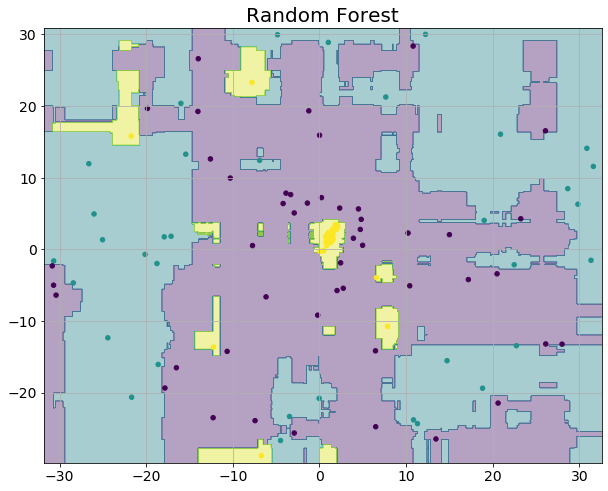

In [25]:
# Plotting decision regions
clf_lr = LogisticRegression( max_iter=1000, C=grid_params['C'], class_weight=grid_params['class_weight'], solver=grid_params['solver'],tol=grid_params['tol'], random_state=random_state)  

#Finding optimal training data size    
pca_num  = 2
trainsize=0.8
rs = random_state

#Split data into training and testing
data = np.copy(waveform_data_ht)
y    = np.copy(y_numeric)
data_train, data_test, y_train, y_test = train_test_split(data, y, train_size=trainsize, test_size=1-trainsize, random_state=rs)

#Standardize the data before applying PCA
SS_data = StandardScaler()
data_train =  SS_data.fit_transform(data_train)
data_test = SS_data.transform(data_test)

#Apply PCA
pca = PCA(svd_solver='full', n_components=pca_num, random_state=random_state)
data_train_pca = pca.fit_transform(data_train)
data_test_pca= pca.transform(data_test)
#print(data_test_pca[:10])
pca_time = time.time() 

clf = RandomForestClassifier(random_state=random_state)
clf.fit(data_train_pca, y_train)

pca1_min, pca1_max = data_train_pca[:, 0].min() - 1, data_train_pca[:, 0].max() + 1
pca2_min, pca2_max = data_train_pca[:, 1].min() - 1, data_train_pca[:, 1].max() + 1

pca1_mesh, pca2_mesh = np.meshgrid(np.arange(pca1_min, pca1_max, 0.1),
                     np.arange(pca2_min, pca2_max, 0.1))

#print(np.shape(data_train_pca))
f, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10, 8))

#for idx, clf, tt in zip(product([0, 1], [0, 1]),
#                        [clf1, clf2, clf3, eclf],
#                        ['Decision Tree (depth=4)', 'KNN (k=7)',
#                         'Kernel SVM', 'Soft Voting']):

Z = clf.predict(np.c_[pca1_mesh.ravel(), pca2_mesh.ravel()])
Z = Z.reshape(pca1_mesh.shape)

ax.contourf(pca1_mesh, pca2_mesh, Z, alpha=0.4)
ax.scatter(data_train_pca[:, 0], data_train_pca[:, 1], c=y_train, s=20)
ax.set_title('Random Forest', fontsize=20)

plt.show()

In [35]:
#Randomized Search - Random Forest Optimization with randomizedsearch 


clf_rf = RandomForestClassifier(n_jobs=1, random_state=random_state)
params={'n_estimators':list(np.arange(10,500,20)),'criterion':['gini', 'entropy'],'max_depth':list(np.arange(5,50,2)),\
        'class_weight':['balanced','None'], 'max_features':[pca_num, 0.5, 1, 'sqrt', 'log2']}
verbose=1 

#Finding optimal training data size    
pca_num  = np.array((2,5,10,15,20,30,40))
trainsize=0.8
rs = random_state


data = np.copy(waveform_data_ht)
y    = np.copy(y_numeric)
data_train, data_test, y_train, y_test = train_test_split(data, y, train_size=trainsize, test_size=1-trainsize, random_state=rs)

#Standardize the data before applying PCA
SS_data = StandardScaler()
data_train =  SS_data.fit_transform(data_train)
data_test = SS_data.transform(data_test)

#standardization_time = time.time() 



print("Randomized Search with Random Forest Classifier\n")
for pca_comp in pca_num:

    #Apply PCA
    pca = PCA(svd_solver='full', n_components=pca_comp, random_state=random_state)
    data_train_pca = pca.fit_transform(data_train)
    data_test_pca= pca.transform(data_test)
    #pca_time = time.time() 
    
    #Perform a grid search over given parameters
    param_grid=params 
    nprocs=-1
    
    #Here we first use randomized search to constraint our parameter space
    rf_random = RandomizedSearchCV(estimator = clf_rf, param_distributions = params, n_iter = 300, cv = 3, verbose=2, random_state=rs, n_jobs = -1)
    #Compute the cross validation, training and test scores
    search.fit(data_train_pca, y_train)
    score_train = search.score(data_train_pca, y_train)
    cv_scores = cross_val_score(search, data_train_pca, y_train, cv=5)
    score_test = search.score(data_test_pca,y_test)
    
    print("PCA components = {}, RF best parameters = {}".format(pca_comp, search.best_params_))

    print("Classes predicted using {} PCA components  = {}".format(pca_comp, le.inverse_transform(clf_class_predictions)))


    print("Training Score = {:.4g}".format(score_train))
    print("CV Score       = {:.4g}".format(cv_scores.mean()))
    print("Test Score     = {:.4g}\n".format(score_test))
    
    


  


Optimized Search - Random Forest Classifier

PCA components = 2, RF best parameters = {'C': 1.0, 'class_weight': 'balanced', 'solver': 'sag', 'tol': 0.1}
Classes predicted using 2 PCA components  = ['AlignedSpins' 'NonSpinning' 'Precessing']
Training Score = 0.4917
CV Score       = 0.3833
Test Score     = 0.3548

PCA components = 5, RF best parameters = {'C': 0.01, 'class_weight': 'balanced', 'solver': 'sag', 'tol': 0.01}
Classes predicted using 5 PCA components  = ['AlignedSpins' 'NonSpinning' 'Precessing']
Training Score = 0.5333
CV Score       = 0.375
Test Score     = 0.3871

PCA components = 10, RF best parameters = {'C': 0.1, 'class_weight': 'balanced', 'solver': 'newton-cg', 'tol': 0.1}
Classes predicted using 10 PCA components  = ['AlignedSpins' 'NonSpinning' 'Precessing']
Training Score = 0.525
CV Score       = 0.375
Test Score     = 0.2903

PCA components = 15, RF best parameters = {'C': 0.01, 'class_weight': None, 'solver': 'newton-cg', 'tol': 0.1}
Classes predicted using 15 

In [75]:
#Default Classifier

#Finding optimal training data size    
pca_num  = np.array((2,5))
trainsize=0.8
rs = random_state

#Split data into training and testing
data = np.copy(waveform_data_ht)
y    = np.copy(y_numeric)
data_train, data_test, y_train, y_test = train_test_split(data, y, train_size=trainsize, test_size=1-trainsize, random_state=rs)

#Standardize the data before applying PCA
SS_data = StandardScaler()
data_train =  SS_data.fit_transform(data_train)
data_test = SS_data.transform(data_test)

print("Training Data after standardization - Mean = {:.4g}, Standard Deviation = {:.4g}".format(data_train.mean(), data_train.std()))
print("Test Data after standardization - Mean = {:.4g}, Standard Deviation = {:.4g} \n\n".format(data_test.mean(), data_test.std()))

print("# PCA Comp    # Classes Predicted \t Train score \t CV score \t Test Score ")
print("-"*100)

score_train, score_test, cv_scores = np.zeros((3, len(pca_num)))

#plt.figure(figsize=(10,6))
for i, pca_comp in enumerate(pca_num[1:]):
    
    #Apply PCA
    pca = PCA(svd_solver='full', n_components=pca_comp, random_state=random_state)
    data_train_pca = pca.fit_transform(data_train)
    data_test_pca= pca.transform(data_test)
    pca_time = time.time() 
    
    
    #Random Forest with default parameters
    clf1 = RandomForestClassifier(random_state=random_state)
    clf1.fit(data_train_pca, y_train)
    print(clf1.get_params())
    #Compute the cross validation, training and test scores
    score_train = clf1.score(data_train_pca, y_train)
    cv_scores = cross_val_score(clf1, data_train_pca, y_train, cv=5).mean()
    score_test = clf1.score(data_test_pca,y_test)
    clf_class_predictions = np.unique(clf1.predict(data_test_pca))
    
    
    print(" %d \t \t \t %d \t\t %.2g \t\t %.2g \t\t %.2g"%(pca_comp, np.size(np.unique(clf_class_predictions)), score_train, \
                                             cv_scores, score_test))
    
    clf2 = RandomForestClassifier(class_weight=None, criterion='entropy', max_depth=None,bootstrap=True,max_features=0.4,\
                                  n_estimators=90,  random_state=random_state)
    clf2.fit(data_train_pca, y_train)
    print(clf2.get_params())
    #Compute the cross validation, training and test scores
    score_train = clf2.score(data_train_pca, y_train)
    cv_scores = cross_val_score(clf2, data_train_pca, y_train, cv=5).mean()
    score_test = clf2.score(data_test_pca,y_test)
    clf_class_predictions = np.unique(clf2.predict(data_test_pca))
    
    
    print(" %d \t \t \t %d \t\t %.2g \t\t %.2g \t\t %.2g"%(pca_comp, np.size(np.unique(clf_class_predictions)), score_train, \
                                             cv_scores, score_test))
    
    #print("Classes predicted using {} PCA components by Logistic regression = {}".format(pca_comp, le.inverse_transform(clf_class_predictions)))
    #print("Logistic Regression with default settings and 2 PCA components - ")
    #print("\t Training Score = {:.4g}".format(score_train))
    #print("\t CV Score       = {:.4g}".format(cv_scores.mean()))
    #print("\t Test Score = {:.4g}".format(score_test))
    
    



Training Data after standardization - Mean = 2.348e-18, Standard Deviation = 1
Test Data after standardization - Mean = 0.002094, Standard Deviation = 1.026 


# PCA Comp    # Classes Predicted 	 Train score 	 CV score 	 Test Score 
----------------------------------------------------------------------------------------------------
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 100, 'verbose': 0, 'warm_start': False}
 5 	 	 	 3 		 1 		 0.82 		 0.81
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 0.4, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_s

Number of PCA components = 2, LR best parameters = {'n_estimators': 30}
 2 	 	 	 3 		 1 		 0.67 		 0.58
Number of PCA components = 5, LR best parameters = {'n_estimators': 70}
 5 	 	 	 3 		 1 		 0.75 		 0.81
Number of PCA components = 10, LR best parameters = {'n_estimators': 130}
 10 	 	 	 3 		 1 		 0.78 		 0.9
Number of PCA components = 15, LR best parameters = {'n_estimators': 30}
 15 	 	 	 3 		 1 		 0.82 		 0.81
Number of PCA components = 20, LR best parameters = {'n_estimators': 130}
 20 	 	 	 3 		 1 		 0.79 		 0.87
Number of PCA components = 30, LR best parameters = {'n_estimators': 110}
 30 	 	 	 3 		 1 		 0.78 		 0.87
Number of PCA components = 40, LR best parameters = {'n_estimators': 50}
 40 	 	 	 3 		 1 		 0.81 		 0.84


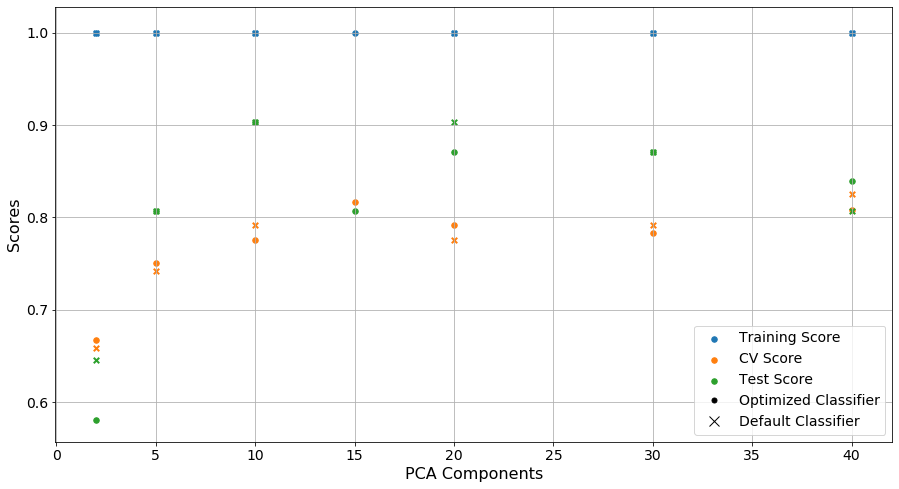

In [285]:
#Random Forest Optimization with gridsearch - Number of Learners 


clf = RandomForestClassifier(n_jobs=1, random_state=random_state)
params={'n_estimators':list(np.arange(30,140,20))}#,'criterion':['gini', 'entropy'],'max_depth':list(np.arange(7,12,1))+[None],\
             #'max_features':[0.4,0.6,0.8,0.999], } #, 'class_weight':['balanced','None'],'bootstrap':[True, False]
verbose=1 

#Finding optimal training data size    
pca_num  = np.array((2,5,10,15,20,30,40))
trainsize=0.8
rs = random_state


data = np.copy(waveform_data_ht)
y    = np.copy(y_numeric)
data_train, data_test, y_train, y_test = train_test_split(data, y, train_size=trainsize, test_size=1-trainsize, random_state=rs)

#Standardize the data before applying PCA
SS_data = StandardScaler()
data_train =  SS_data.fit_transform(data_train)
data_test = SS_data.transform(data_test)

#standardization_time = time.time() 

score_train, score_test, cv_scores = np.zeros((3, len(pca_num)))

for i, pca_comp in enumerate(pca_num):

    #Apply PCA
    pca = PCA(svd_solver='full', n_components=pca_comp, random_state=random_state)
    data_train_pca = pca.fit_transform(data_train)
    data_test_pca= pca.transform(data_test)
    #pca_time = time.time() 
    
    #Perform a grid search over given parameters
    param_grid=params 
    nprocs=-1
    
    #Here we search over entire grid of parameters instead of random sampling since our data size is small. For 
    #very large data, RandommizedSearchCV should be preferred. 
    
    search = GridSearchCV(clf, param_grid, cv=5, n_jobs=nprocs)

    #Compute the cross validation, training and test scores
    search.fit(data_train_pca, y_train)
    score_train[i] = search.score(data_train_pca, y_train)
    cv_scores[i] = cross_val_score(search, data_train_pca, y_train, cv=5).mean()
    score_test[i] = search.score(data_test_pca,y_test)
    print("Number of PCA components = {}, LR best parameters = {}".format(pca_comp, search.best_params_))
    print(" %d \t \t \t %d \t\t %.2g \t\t %.2g \t\t %.2g"%(pca_comp, np.size(np.unique(clf_class_predictions)), score_train[i], \
                                             cv_scores[i], score_test[i]))
    
rf_optscores_dict = {'pca':pca_num, 'train_score':score_train, 'cv_score': cv_scores, 'test_score':score_test}

  
#Plots
plt.figure(figsize=(15,8))

train_plot = plt.scatter(rf_optscores_dict['pca'], rf_optscores_dict['train_score'], marker='o',  s=30, c='C0', label='Training Score')
cv_plot    = plt.scatter(rf_optscores_dict['pca'], rf_optscores_dict['cv_score'], marker='o',  s=30, c='C1', label='CV Score')
test_plot  = plt.scatter(rf_optscores_dict['pca'], rf_optscores_dict['test_score'], marker='o', s=30, c='C2', label='Test Score')

plt.scatter(rf_rawscores_dict['pca'], rf_rawscores_dict['train_score'], marker='x', s=30, c='C0')
plt.scatter(rf_rawscores_dict['pca'], rf_rawscores_dict['cv_score'], marker='x', s=30, c='C1')
plt.scatter(rf_rawscores_dict['pca'], rf_rawscores_dict['test_score'], marker='x', s=30, c='C2')

opt_params = mlines.Line2D([], [], color='k', marker='.', linestyle='None',
                          markersize=10, label='Optimized Classifier')
def_params = mlines.Line2D([], [], color='k', marker='x', linestyle='None',
                          markersize=10, label='Default Classifier')

plt.xlabel('PCA Components')
plt.ylabel('Scores')
plt.legend(handles = [train_plot, cv_plot, test_plot, opt_params, def_params])
plt.show()
plt.close()
   


Number of PCA components = 2, LR best parameters = {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 8, 'max_features': 0.4}
 2 	 	 	 3 		 1 		 0.67 		 0.61
Number of PCA components = 5, LR best parameters = {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 8, 'max_features': 0.8}
 5 	 	 	 3 		 1 		 0.75 		 0.77
Number of PCA components = 10, LR best parameters = {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 8, 'max_features': 0.4}
 10 	 	 	 3 		 1 		 0.79 		 0.94
Number of PCA components = 15, LR best parameters = {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'max_features': 0.4}
 15 	 	 	 3 		 0.99 		 0.78 		 0.9
Number of PCA components = 20, LR best parameters = {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 7, 'max_features': 0.4}
 20 	 	 	 3 		 1 		 0.78 		 0.87
Number of PCA components = 30, LR best

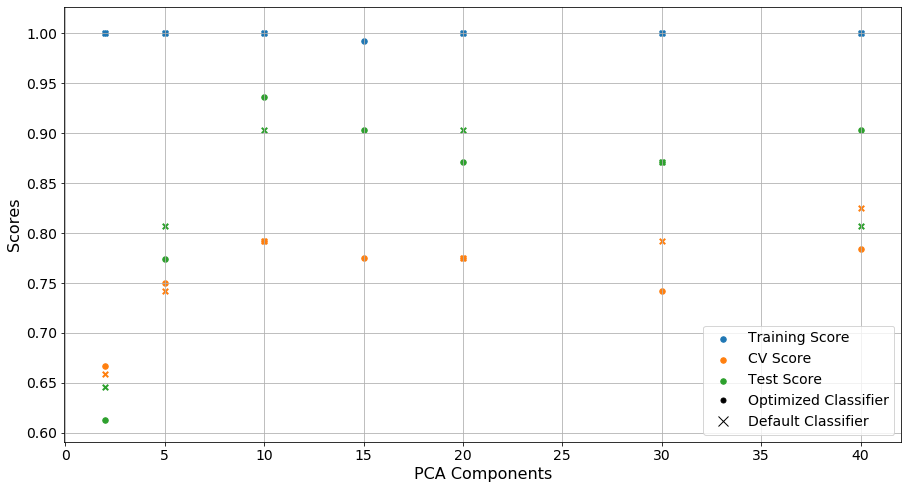

In [289]:
#Random Forest Optimization with gridsearch - Number of Learners 


clf = RandomForestClassifier(n_estimators=130,n_jobs=1, random_state=random_state)
params={'criterion':['gini', 'entropy'],'max_depth':list(np.arange(7,12,1))+[None],'max_features':[0.4,0.6,0.8,0.999], 'class_weight':['balanced','None'],'bootstrap':[True, False]}
verbose=1 

#Finding optimal training data size    
pca_num  = np.array((2,5,10,15,20,30,40))
trainsize=0.8
rs = random_state


data = np.copy(waveform_data_ht)
y    = np.copy(y_numeric)
data_train, data_test, y_train, y_test = train_test_split(data, y, train_size=trainsize, test_size=1-trainsize, random_state=rs)

#Standardize the data before applying PCA
SS_data = StandardScaler()
data_train =  SS_data.fit_transform(data_train)
data_test = SS_data.transform(data_test)

#standardization_time = time.time() 

score_train, score_test, cv_scores = np.zeros((3, len(pca_num)))

for i, pca_comp in enumerate(pca_num):

    #Apply PCA
    pca = PCA(svd_solver='full', n_components=pca_comp, random_state=random_state)
    data_train_pca = pca.fit_transform(data_train)
    data_test_pca= pca.transform(data_test)
    #pca_time = time.time() 
    
    #Perform a grid search over given parameters
    param_grid=params 
    nprocs=-1
    
    #Here we search over entire grid of parameters instead of random sampling since our data size is small. For 
    #very large data, RandommizedSearchCV should be preferred. 
    
    search = GridSearchCV(clf, param_grid, cv=5, n_jobs=nprocs)

    #Compute the cross validation, training and test scores
    search.fit(data_train_pca, y_train)
    score_train[i] = search.score(data_train_pca, y_train)
    cv_scores[i] = cross_val_score(search, data_train_pca, y_train, cv=5).mean()
    score_test[i] = search.score(data_test_pca,y_test)
    print("Number of PCA components = {}, LR best parameters = {}".format(pca_comp, search.best_params_))
    print(" %d \t \t \t %d \t\t %.2g \t\t %.2g \t\t %.2g"%(pca_comp, np.size(np.unique(clf_class_predictions)), score_train[i], \
                                             cv_scores[i], score_test[i]))
    
rf_optscores_dict = {'pca':pca_num, 'train_score':score_train, 'cv_score': cv_scores, 'test_score':score_test}

  
#Plots
plt.figure(figsize=(15,8))

train_plot = plt.scatter(rf_optscores_dict['pca'], rf_optscores_dict['train_score'], marker='o',  s=30, c='C0', label='Training Score')
cv_plot    = plt.scatter(rf_optscores_dict['pca'], rf_optscores_dict['cv_score'], marker='o',  s=30, c='C1', label='CV Score')
test_plot  = plt.scatter(rf_optscores_dict['pca'], rf_optscores_dict['test_score'], marker='o', s=30, c='C2', label='Test Score')

plt.scatter(rf_rawscores_dict['pca'], rf_rawscores_dict['train_score'], marker='x', s=30, c='C0')
plt.scatter(rf_rawscores_dict['pca'], rf_rawscores_dict['cv_score'], marker='x', s=30, c='C1')
plt.scatter(rf_rawscores_dict['pca'], rf_rawscores_dict['test_score'], marker='x', s=30, c='C2')

opt_params = mlines.Line2D([], [], color='k', marker='.', linestyle='None',
                          markersize=10, label='Optimized Classifier')
def_params = mlines.Line2D([], [], color='k', marker='x', linestyle='None',
                          markersize=10, label='Default Classifier')

plt.xlabel('PCA Components')
plt.ylabel('Scores')
plt.legend(handles = [train_plot, cv_plot, test_plot, opt_params, def_params])
plt.show()
plt.close()
   


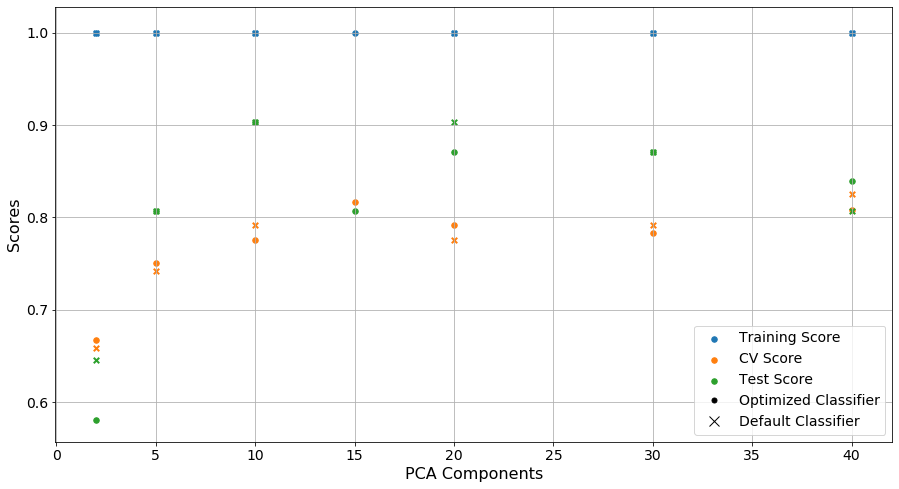

In [284]:
#Plots
plt.figure(figsize=(15,8))

train_plot = plt.scatter(rf_optscores_dict['pca'], rf_optscores_dict['train_score'], marker='o',  s=30, c='C0', label='Training Score')
cv_plot    = plt.scatter(rf_optscores_dict['pca'], rf_optscores_dict['cv_score'], marker='o',  s=30, c='C1', label='CV Score')
test_plot  = plt.scatter(rf_optscores_dict['pca'], rf_optscores_dict['test_score'], marker='o', s=30, c='C2', label='Test Score')

plt.scatter(rf_rawscores_dict['pca'], rf_rawscores_dict['train_score'], marker='x', s=30, c='C0')
plt.scatter(rf_rawscores_dict['pca'], rf_rawscores_dict['cv_score'], marker='x', s=30, c='C1')
plt.scatter(rf_rawscores_dict['pca'], rf_rawscores_dict['test_score'], marker='x', s=30, c='C2')

opt_params = mlines.Line2D([], [], color='k', marker='.', linestyle='None',
                          markersize=10, label='Optimized Classifier')
def_params = mlines.Line2D([], [], color='k', marker='x', linestyle='None',
                          markersize=10, label='Default Classifier')

plt.xlabel('PCA Components')
plt.ylabel('Scores')
plt.legend(handles = [train_plot, cv_plot, test_plot, opt_params, def_params])
plt.show()
plt.close()
   

### Classifier : Support Vector Machines (SVM)

__Parameters to play with -__

To optimize SVM classifier, we look at the following parameters - 
* Kernel - Changes the basis used for projection - optimization over linear, polynomial, radidal basis function and sigmoid
* C - Regularization parameter which controls the penalty for each misclassification - varied of 1 to 10 (other values tried but C remained in between these)
* Weights - Scales penalty of each class by changing C -> w*C - Three variations considered - equal weights, balanced weights and biased weights (based on PCA distribution)
* Decision Function shape - fix to 'ovr' - one vs rest (n SVM Classifier build where n is number of classes) 

__Method -__
* Scale data with zero mean and unit variance
* Perform PCA transformation followed by grid search
* To find weights we use more crude hit and trial method. We first optimize over Kernel and C with equal weights and then play with weight parameters for each class to improve the performance. 
* To optimize the speed - 
  * Check if training data array is C-contiguous and double precision (check flags of np array)
  * Set cache size to 500-1000 MB




# PCA Comp    # Classes Predicted 	 Train score 	 CV score 	 Test Score 
 2 	 	 	 3 		 0.63 		 0.57 		 0.57
 5 	 	 	 3 		 0.77 		 0.66 		 0.7
 10 	 	 	 3 		 0.86 		 0.77 		 0.7
 20 	 	 	 3 		 0.9 		 0.77 		 0.78
 30 	 	 	 3 		 0.92 		 0.77 		 0.78
 40 	 	 	 3 		 0.92 		 0.77 		 0.78


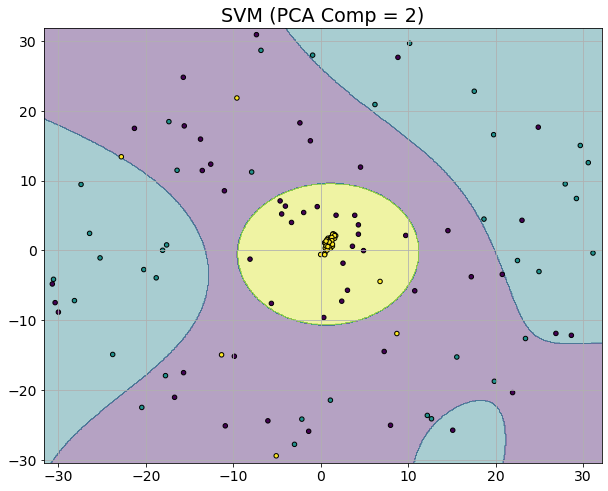

In [252]:
#Default SVM classifier

#Finding optimal training data size    
n  = 0.85
pca_num  = np.array((2,5,10,20,30,40))
#rf_orig = ml_classifier(clf, params, waveform_data_ht, y_numeric, n, pca_num, random_state, plot_decisiontree=False, verbose=0,parallelize=False)

#Split data into training and testing
data = np.copy(waveform_data_ht)
y    = np.copy(y_numeric)
data_train, data_test, y_train, y_test = train_test_split(data, y, train_size=trainsize, test_size=1-trainsize, random_state=rs)

#Standardize the data before applying PCA
SS_data = StandardScaler()
data_train =  SS_data.fit_transform(data_train)
data_test = SS_data.transform(data_test)

#Apply PCA
svm_rawscores_dict = {}
svm_test_score, svm_cv_score, svm_train_score = np.zeros((3, len(pca_num)))

print("# PCA Comp    # Classes Predicted \t Train score \t CV score \t Test Score ")
for i, pca_comp in enumerate(pca_num):
    
    pca = PCA(svd_solver='full', n_components=pca_comp, random_state=random_state)
    data_train_pca = pca.fit_transform(data_train)
    data_test_pca= pca.transform(data_test)
    pca_time = time.time() 
    
    #SVM with default parameters
    clf = SVC(random_state=random_state)  
    clf.fit(data_train_pca, y_train)
    
    #Compute the cross validation, training and test scores
    svm_train_score[i] = clf.score(data_train_pca, y_train)
    svm_cv_score[i] = (cross_val_score(clf, data_train_pca, y_train, cv=5)).mean()
    svm_test_score[i] = clf.score(data_test_pca,y_test)
    clf_class_predictions = np.unique(clf.predict(data_test_pca))
    

    print(" %d \t \t \t %d \t\t %.2g \t\t %.2g \t\t %.2g"%(pca_comp, np.size(np.unique(clf_class_predictions)), svm_train_score[i], \
                                             svm_cv_score[i], svm_test_score[i]))
    
    #print("Classes predicted by Random Forest = {}".format(le.inverse_transform(clf_class_predictions)))
    #print("SVM with default settings and {%d} PCA components - "%pca_comp)
    #print("\t Training Score = {:.4g}".format(svm_train_score[i]))
    #print("\t CV Score       = {:.4g}".format(svm_cv_score[i]))
    #print("\t Test Score = {:.4g}".format(svm_test_score[i]))
    
    
    # Plotting decision regions
    if pca_comp==2:
        pca1_min, pca1_max = data_train_pca[:, 0].min() - 1, data_train_pca[:, 0].max() + 1
        pca2_min, pca2_max = data_train_pca[:, 1].min() - 1, data_train_pca[:, 1].max() + 1
        
        pca1_mesh, pca2_mesh = np.meshgrid(np.arange(pca1_min, pca1_max, 0.1),
                             np.arange(pca2_min, pca2_max, 0.1))
        
        Z = clf.predict(np.c_[pca1_mesh.ravel(), pca2_mesh.ravel()])
        Z = Z.reshape(pca1_mesh.shape)
        
        
        f, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10, 8))
        
        ax.contourf(pca1_mesh, pca2_mesh, Z, alpha=0.4)
        ax.scatter(data_train_pca[:, 0], data_train_pca[:, 1], c=y_train, s=20, edgecolor='k')
        ax.set_title('SVM (PCA Comp = 2)')
        
plt.show()
                                             
                          
svm_rawscores_dict['pca'] = pca_num
svm_rawscores_dict['test_score'] = svm_test_score
svm_rawscores_dict['train_score'] = svm_train_score
svm_rawscores_dict['cv_score'] = svm_cv_score

                                          

In [189]:
#SVM Kernel and Regularization Strength Optimization with gridsearch and PCA components

clf = SVC(decision_function_shape='ovr',cache_size=500, random_state=random_state)  
params={'kernel':['linear','poly', 'rbf', 'sigmoid'],  'C':[ 0.5,1, 3,5,7,9]}

kernel_dict = {'linear':0, 'poly':0, 'rbf':0, 'sigmoid':0}
reg_strength_dict = {'0.5':0,'1':0,'3':0,'5':0,'7':0,'9':0}
#params={'C':10.**np.arange(0,2,0.4), 'class_weight':['None', 'balanced'],'kernel':['linear','poly', 'rbf', 'sigmoid'],\
#       'degree':[2,3,4,5], 'gamma':['auto', 'scaled']}
verbose=1 


pca_num  = np.array((2,5,10,20,30,40))
trainsize=0.85
rs = random_state


data = np.copy(waveform_data_ht)
y    = np.copy(y_numeric)
data_train, data_test, y_train, y_test = train_test_split(data, y, train_size=trainsize, test_size=1-trainsize, random_state=rs)

#Standardize the data before applying PCA
SS_data = StandardScaler()
data_train =  SS_data.fit_transform(data_train)
data_test = SS_data.transform(data_test)

plt.figure(figsize=(15,8))
#standardization_time = time.time() 

print("# PCA Comp    # Classes Predicted \t Train score \t CV score \t Test Score ")

for pca_comp in pca_num:

    #Apply PCA
    pca = PCA(svd_solver='full', n_components=pca_comp, random_state=random_state)
    data_train_pca = pca.fit_transform(data_train)
    data_test_pca= pca.transform(data_test)
    pca_time = time.time() 
    
    #Perform a grid search over given parameters
    param_grid=params 
    nprocs=-1
    search = GridSearchCV(clf, param_grid, cv=5, n_jobs=nprocs)

    #Compute the cross validation, training and test scores
    search.fit(data_train_pca, y_train)
    score_train = search.score(data_train_pca, y_train)
    cv_scores = cross_val_score(search, data_train_pca, y_train, cv=5)
    score_test = search.score(data_test_pca,y_test)
    clf_class_predictions = np.unique(search.predict(data_test_pca))

    kernel = search.best_params_['kernel']
    C = str(search.best_params_['C'])
    kernel_dict[kernel]+=1
    reg_strength_dict[C]+=1
    #print("Number of PCA components = {}, LR best parameters = {}".format(pca_comp, search.best_params_))
    #print("Classes predicted by Random Forest = {}".format(le.inverse_transform(clf_class_predictions)))

    print(" %d \t \t \t %d \t\t %.2g \t\t %.2g \t\t %.2g"%(pca_comp, np.size(np.unique(clf_class_predictions)), score_train, \
                                             cv_scores.mean(), score_test))
    
    if pca_comp==pca_num[0]:
        plt.scatter(pca_comp, score_train, facecolors='none', edgecolors='C0' , marker='o', s=50)
        plt.scatter(pca_comp, cv_scores.mean(), facecolors='none', edgecolors='C1', marker='o', s=50)
        plt.scatter(pca_comp, score_test, facecolors='none', edgecolors='C2', marker='o', s=50 )
    else:
        plt.scatter(pca_comp, score_train, marker='o', s=50, facecolors='none', edgecolors='C0' )
        plt.scatter(pca_comp, cv_scores.mean(),marker='o', s=50,facecolors='none', edgecolors='C1'  )
        plt.scatter(pca_comp, score_test, marker='o', s=50,facecolors='none', edgecolors='C2' )
        
train_plot = plt.scatter(svm_rawscores_dict['pca'], svm_rawscores_dict['train_score'], marker='x', s=30, c='C0', label='Training Score')
cv_plot = plt.scatter(svm_rawscores_dict['pca'], svm_rawscores_dict['cv_score'], marker='x', s=30, c='C1',label='CV Score')
test_plot = plt.scatter(svm_rawscores_dict['pca'], svm_rawscores_dict['test_score'], marker='x', s=30, c='C2', label='Testing Score')

opt_params = mlines.Line2D([], [], color='k', marker='.', linestyle='None',
                          markersize=10, label='Optimized Kernel')
def_params = mlines.Line2D([], [], color='k', marker='x', linestyle='None',
                          markersize=10, label='Default Classifier')


plt.xlabel('PCA Components')
plt.ylabel('Scores')
plt.legend(handles = [train_plot, cv_plot, test_plot, opt_params, def_params])
#plt.show()
plt.close()
   

# PCA Comp    # Classes Predicted 	 Train score 	 CV score 	 Test Score 
 2 	 	 	 3 		 0.78 		 0.59 		 0.61
 5 	 	 	 3 		 0.91 		 0.74 		 0.74
 10 	 	 	 3 		 0.92 		 0.77 		 0.7
 20 	 	 	 3 		 0.99 		 0.76 		 0.7
 30 	 	 	 3 		 0.99 		 0.78 		 0.78
 40 	 	 	 3 		 0.99 		 0.8 		 0.83


In [219]:
#SVM Regularization Weights Optimization with gridsearch and PCA components

for key in kernel_dict.keys():
    if kernel_dict[key]==max(kernel_dict.values()):
        opt_kernel = key
        
for key in reg_strength_dict.keys():
    if reg_strength_dict[key]==max(reg_strength_dict.values()):
        opt_C = key
   

clf = SVC(kernel=opt_kernel, C=float(opt_C), decision_function_shape='ovr',cache_size=500, random_state=random_state)  
#params={'kernel':['linear','poly', 'rbf', 'sigmoid']}

params = {'class_weight':['balanced',{0:5, 1:10, 2:1}, {0:7, 1:12, 2:3}]}
verbose=1 

#Finding optimal training data size    
pca_num  = np.array((2,5,10,20,30,40))
trainsize=0.85
rs = random_state


data = np.copy(waveform_data_ht)
y    = np.copy(y_numeric)
data_train, data_test, y_train, y_test = train_test_split(data, y, train_size=trainsize, test_size=1-trainsize, random_state=rs)

#Standardize the data before applying PCA
SS_data = StandardScaler()
data_train =  SS_data.fit_transform(data_train)
data_test = SS_data.transform(data_test)


plt.figure(figsize=(15,8))
print("# PCA Comp    # Classes Predicted \t Train score \t CV score \t Test Score ")
#standardization_time = time.time() 

for pca_comp in pca_num:

    #Apply PCA
    pca = PCA(svd_solver='full', n_components=pca_comp, random_state=random_state)
    data_train_pca = pca.fit_transform(data_train)
    data_test_pca= pca.transform(data_test)
    pca_time = time.time() 
    
    #Perform a grid search over given parameters
    param_grid=params 
    nprocs=-1
    search = GridSearchCV(clf, param_grid, cv=5, n_jobs=nprocs)

    #Compute the cross validation, training and test scores
    search.fit(data_train_pca, y_train)
    score_train = search.score(data_train_pca, y_train)
    cv_scores = cross_val_score(search, data_train_pca, y_train, cv=5)
    score_test = search.score(data_test_pca,y_test)
    clf_class_predictions = np.unique(search.predict(data_test_pca))

    print(" %d \t \t \t %d \t\t %.2g \t\t %.2g \t\t %.2g"%(pca_comp, np.size(np.unique(clf_class_predictions)), score_train, \
                                             cv_scores.mean(), score_test))
    
    #print("Number of PCA components = {}, LR best parameters = {}".format(pca_comp, search.best_params_))
    ##print("Classes predicted by SVM = {}".format(le.inverse_transform(clf_class_predictions)))
    #print("\t Training Score = {:.4g}".format(score_train))
    #print("\t CV Score       = {:.4g}".format(cv_scores.mean()))
    #print("\t Test Score = {:.4g}".format(score_test))
    
    
    if pca_comp==pca_num[0]:
        plt.scatter(pca_comp, score_train, facecolors='none', edgecolors='C0' , marker='o', s=50)
        plt.scatter(pca_comp, cv_scores.mean(), facecolors='none', edgecolors='C1', marker='o', s=50 )
        plt.scatter(pca_comp, score_test, facecolors='none', edgecolors='C2', marker='o', s=50 )
    else:
        plt.scatter(pca_comp, score_train, marker='o', s=50, facecolors='none', edgecolors='C0' )
        plt.scatter(pca_comp, cv_scores.mean(), marker='o', s=50,facecolors='none', edgecolors='C1' )
        plt.scatter(pca_comp, score_test, marker='o', s=50,facecolors='none', edgecolors='C2' )
        
train_plot = plt.scatter(svm_rawscores_dict['pca'], svm_rawscores_dict['train_score'], marker='x', s=30, c='C0', label='Training Score')
cv_plot = plt.scatter(svm_rawscores_dict['pca'], svm_rawscores_dict['cv_score'], marker='x', s=30, c='C1',label='CV Score')
test_plot = plt.scatter(svm_rawscores_dict['pca'], svm_rawscores_dict['test_score'], marker='x', s=30, c='C2', label='Testing Score')

opt_params = mlines.Line2D([], [], color='k', marker='.', linestyle='None',
                          markersize=10, label='Optimized Kernel')
def_params = mlines.Line2D([], [], color='k', marker='x', linestyle='None',
                          markersize=10, label='Default Classifier')

plt.legend(handles = [train_plot, cv_plot, test_plot, opt_params, def_params])

plt.xlabel('PCA Components')
plt.ylabel('Scores')
#plt.show()
plt.close()
   

# PCA Comp    # Classes Predicted 	 Train score 	 CV score 	 Test Score 
 2 	 	 	 3 		 0.85 		 0.7 		 0.57
 5 	 	 	 3 		 0.98 		 0.8 		 0.74
 10 	 	 	 3 		 0.95 		 0.78 		 0.74
 20 	 	 	 3 		 1 		 0.77 		 0.74
 30 	 	 	 3 		 1 		 0.8 		 0.78
 40 	 	 	 3 		 1 		 0.8 		 0.83


# PCA Comp    # Classes Predicted 	 Train score 	 CV score 	 Test Score 
 2 	 	 	 3 		 0.85 		 0.7 		 0.57
 5 	 	 	 3 		 0.98 		 0.82 		 0.74
 10 	 	 	 3 		 0.98 		 0.78 		 0.78
 20 	 	 	 3 		 1 		 0.77 		 0.74
 30 	 	 	 3 		 1 		 0.8 		 0.78
 40 	 	 	 3 		 1 		 0.81 		 0.83


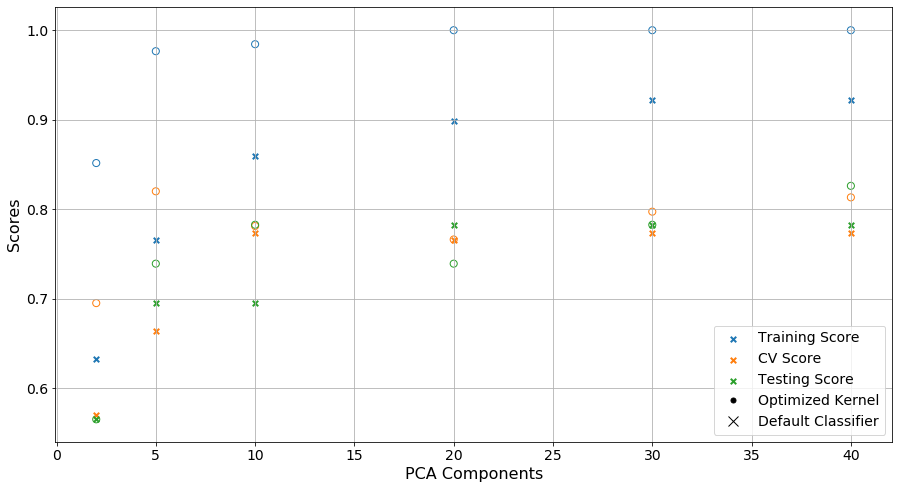

In [253]:
#SVM  Optimization with gridsearch and PCA components

clf = SVC(class_weight={0:7, 1:12, 2:3},kernel=opt_kernel, C=float(opt_C), decision_function_shape='ovr',cache_size=500, random_state=random_state)  
verbose=1 
params={}

#Finding optimal training data size    
pca_num  = np.array((2,5,10,20,30, 40))
trainsize=0.85
rs = random_state


data = np.copy(waveform_data_ht)
y    = np.copy(y_numeric)
data_train, data_test, y_train, y_test = train_test_split(data, y, train_size=trainsize, test_size=1-trainsize, random_state=rs)

#Standardize the data before applying PCA
SS_data = StandardScaler()
data_train =  SS_data.fit_transform(data_train)
data_test = SS_data.transform(data_test)


plt.figure(figsize=(15,8))
print("# PCA Comp    # Classes Predicted \t Train score \t CV score \t Test Score ")

#standardization_time = time.time() 


for pca_comp in pca_num:

    #Apply PCA
    pca = PCA(svd_solver='full', n_components=pca_comp, random_state=random_state)
    data_train_pca = pca.fit_transform(data_train)
    data_test_pca= pca.transform(data_test)
    pca_time = time.time() 
    
    #Perform a grid search over given parameters
    param_grid=params 
    nprocs=-1
    search = GridSearchCV(clf, param_grid, cv=5, n_jobs=nprocs)

    #Compute the cross validation, training and test scores
    search.fit(data_train_pca, y_train)
    score_train = search.score(data_train_pca, y_train)
    cv_scores = cross_val_score(search, data_train_pca, y_train, cv=5)
    score_test = search.score(data_test_pca,y_test)
    clf_class_predictions = np.unique(search.predict(data_test_pca))

    print(" %d \t \t \t %d \t\t %.2g \t\t %.2g \t\t %.2g"%(pca_comp, np.size(np.unique(clf_class_predictions)), score_train, \
                                             cv_scores.mean(), score_test))
   
    #print("Number of PCA components = {}, LR best parameters = {}".format(pca_comp, search.best_params_))
    #print("Classes predicted by SVM = {}".format(le.inverse_transform(clf_class_predictions)))
    #print("\t Training Score = {:.4g}".format(score_train))
    #print("\t CV Score       = {:.4g}".format(cv_scores.mean()))
    #print("\t Test Score = {:.4g}".format(score_test))
    
    
    if pca_comp==pca_num[0]:
        plt.scatter(pca_comp, score_train, facecolors='none', edgecolors='C0' , marker='o', s=50)
        plt.scatter(pca_comp, cv_scores.mean(), facecolors='none', edgecolors='C1', marker='o', s=50 )
        plt.scatter(pca_comp, score_test, facecolors='none', edgecolors='C2', marker='o', s=50 )
    else:
        plt.scatter(pca_comp, score_train, marker='o', s=50, facecolors='none', edgecolors='C0' )
        plt.scatter(pca_comp, cv_scores.mean(), marker='o', s=50,facecolors='none', edgecolors='C1' )
        plt.scatter(pca_comp, score_test, marker='o', s=50,facecolors='none', edgecolors='C2' )
        
train_plot = plt.scatter(svm_rawscores_dict['pca'], svm_rawscores_dict['train_score'], marker='x', s=30, c='C0', label='Training Score')
cv_plot = plt.scatter(svm_rawscores_dict['pca'], svm_rawscores_dict['cv_score'], marker='x', s=30, c='C1',label='CV Score')
test_plot = plt.scatter(svm_rawscores_dict['pca'], svm_rawscores_dict['test_score'], marker='x', s=30, c='C2', label='Testing Score')

opt_params = mlines.Line2D([], [], color='k', marker='.', linestyle='None',
                          markersize=10, label='Optimized Kernel')
def_params = mlines.Line2D([], [], color='k', marker='x', linestyle='None',
                          markersize=10, label='Default Classifier')

plt.legend(handles = [train_plot, cv_plot, test_plot, opt_params, def_params])

plt.xlabel('PCA Components')
plt.ylabel('Scores')
plt.show()
plt.close()
   

# PCA Comp    # Classes Predicted 	 Train score 	 CV score 	 Test Score 
 40 	 	 	 3 		 0.85 		 0.7 		 0.57


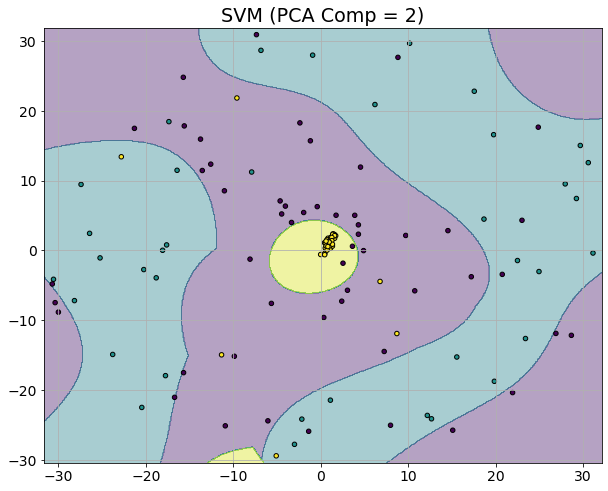

In [233]:
#Decision surface for two PCA components
clf = SVC(class_weight={0:7, 1:12, 2:3},kernel=opt_kernel, C=float(opt_C), decision_function_shape='ovr',cache_size=500, random_state=random_state)  
verbose=1 
params={}

#Finding optimal training data size    
pca_num  = 2
trainsize=0.85
rs = random_state


data = np.copy(waveform_data_ht)
y    = np.copy(y_numeric)
data_train, data_test, y_train, y_test = train_test_split(data, y, train_size=trainsize, test_size=1-trainsize, random_state=rs)

#Standardize the data before applying PCA
SS_data = StandardScaler()
data_train =  SS_data.fit_transform(data_train)
data_test = SS_data.transform(data_test)

print("# PCA Comp    # Classes Predicted \t Train score \t CV score \t Test Score ")


#Apply PCA
pca = PCA(svd_solver='full', n_components=pca_num, random_state=random_state)
data_train_pca = pca.fit_transform(data_train)
data_test_pca= pca.transform(data_test)


#Compute the cross validation, training and test scores
clf.fit(data_train_pca, y_train)
score_train = clf.score(data_train_pca, y_train)
cv_scores = cross_val_score(clf, data_train_pca, y_train, cv=5)
score_test = clf.score(data_test_pca,y_test)
clf_class_predictions = np.unique(clf.predict(data_test_pca))

print(" %d \t \t \t %d \t\t %.2g \t\t %.2g \t\t %.2g"%(pca_comp, np.size(np.unique(clf_class_predictions)), score_train, \
                                         cv_scores.mean(), score_test))

#print("Number of PCA components = {}, LR best parameters = {}".format(pca_comp, search.best_params_))
#print("Classes predicted by SVM = {}".format(le.inverse_transform(clf_class_predictions)))
#print("\t Training Score = {:.4g}".format(score_train))
#print("\t CV Score       = {:.4g}".format(cv_scores.mean()))
#print("\t Test Score = {:.4g}".format(score_test))

# Plotting decision regions

pca1_min, pca1_max = data_train_pca[:, 0].min() - 1, data_train_pca[:, 0].max() + 1
pca2_min, pca2_max = data_train_pca[:, 1].min() - 1, data_train_pca[:, 1].max() + 1

pca1_mesh, pca2_mesh = np.meshgrid(np.arange(pca1_min, pca1_max, 0.1),
                     np.arange(pca2_min, pca2_max, 0.1))

Z = clf.predict(np.c_[pca1_mesh.ravel(), pca2_mesh.ravel()])
Z = Z.reshape(pca1_mesh.shape)


f, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10, 8))

ax.contourf(pca1_mesh, pca2_mesh, Z, alpha=0.4)
ax.scatter(data_train_pca[:, 0], data_train_pca[:, 1], c=y_train, s=20, edgecolor='k')
ax.set_title('SVM (PCA Comp = 2)')
    
plt.show()
                                             


###  K-Nearest Neighbours (KNN)

KNN utilizes instance based learning approach by choosing K nearest neighbours and predicting the output using majority vote. SKLearn allows two ways to compute the majority weight - first using uniform weights to all the neighbours and second by assigning the weights based on inverse distance metric. To compute the distance, it again uses two different ways - L1 norm and L2 norm. We search over these three parameters to find the best scores. 

__Parameters__ - 
* n_neighbours - Number of nearest neighbours
* Weight - weight for each neighbour's vote
* p - Distance parameter


__Results__:
* We see that for most training data size vote of small number of nearest neighbours work well. The weight itself can be uniform or weighted by distance from the original point computed using L1 norm. 
* While the training scores are perfect, CV scores are ~85% which is better than most other algorithms. Test scores however are lower ranging from 70-80%.
* This method is also extremely fast compared to few previous methods. 


# PCA Comp    # Classes Predicted 	 Train score 	 CV score 	 Test Score 
 2 	 	 	 3 		 0.8 		 0.67 		 0.52
 5 	 	 	 3 		 0.85 		 0.73 		 0.74
 10 	 	 	 3 		 0.83 		 0.77 		 0.78
 20 	 	 	 3 		 0.82 		 0.77 		 0.7
 30 	 	 	 3 		 0.84 		 0.77 		 0.74
 40 	 	 	 3 		 0.84 		 0.78 		 0.78


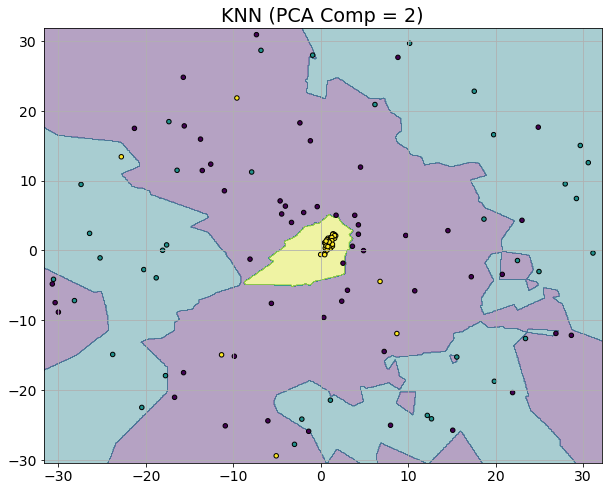

In [239]:
#Default KNN classifier

#Finding optimal training data size    
n  = 0.85
pca_num  = np.array((2,5,10,20,30,40))
#rf_orig = ml_classifier(clf, params, waveform_data_ht, y_numeric, n, pca_num, random_state, plot_decisiontree=False, verbose=0,parallelize=False)

#Split data into training and testing
data = np.copy(waveform_data_ht)
y    = np.copy(y_numeric)
data_train, data_test, y_train, y_test = train_test_split(data, y, train_size=trainsize, test_size=1-trainsize, random_state=rs)

#Standardize the data before applying PCA
SS_data = StandardScaler()
data_train =  SS_data.fit_transform(data_train)
data_test = SS_data.transform(data_test)

#Apply PCA
svm_rawscores_dict = {}
svm_test_score, svm_cv_score, svm_train_score = np.zeros((3, len(pca_num)))

print("# PCA Comp    # Classes Predicted \t Train score \t CV score \t Test Score ")
for i, pca_comp in enumerate(pca_num):
    
    pca = PCA(svd_solver='full', n_components=pca_comp, random_state=random_state)
    data_train_pca = pca.fit_transform(data_train)
    data_test_pca= pca.transform(data_test)
    pca_time = time.time() 
    
    #SVM with default parameters
    clf = KNeighborsClassifier()
    clf.fit(data_train_pca, y_train)
    
    #Compute the cross validation, training and test scores
    svm_train_score[i] = clf.score(data_train_pca, y_train)
    svm_cv_score[i] = (cross_val_score(clf, data_train_pca, y_train, cv=5)).mean()
    svm_test_score[i] = clf.score(data_test_pca,y_test)
    clf_class_predictions = np.unique(clf.predict(data_test_pca))
    

    print(" %d \t \t \t %d \t\t %.2g \t\t %.2g \t\t %.2g"%(pca_comp, np.size(np.unique(clf_class_predictions)), svm_train_score[i], \
                                             svm_cv_score[i], svm_test_score[i]))
    
    #print("Classes predicted by Random Forest = {}".format(le.inverse_transform(clf_class_predictions)))
    #print("SVM with default settings and {%d} PCA components - "%pca_comp)
    #print("\t Training Score = {:.4g}".format(svm_train_score[i]))
    #print("\t CV Score       = {:.4g}".format(svm_cv_score[i]))
    #print("\t Test Score = {:.4g}".format(svm_test_score[i]))
    
    
    # Plotting decision regions
    if pca_comp==2:
        pca1_min, pca1_max = data_train_pca[:, 0].min() - 1, data_train_pca[:, 0].max() + 1
        pca2_min, pca2_max = data_train_pca[:, 1].min() - 1, data_train_pca[:, 1].max() + 1
        
        pca1_mesh, pca2_mesh = np.meshgrid(np.arange(pca1_min, pca1_max, 0.1),
                             np.arange(pca2_min, pca2_max, 0.1))
        
        Z = clf.predict(np.c_[pca1_mesh.ravel(), pca2_mesh.ravel()])
        Z = Z.reshape(pca1_mesh.shape)
        
        
        f, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10, 8))
        
        ax.contourf(pca1_mesh, pca2_mesh, Z, alpha=0.4)
        ax.scatter(data_train_pca[:, 0], data_train_pca[:, 1], c=y_train, s=20, edgecolor='k')
        ax.set_title('KNN (PCA Comp = 2)')
        
plt.show()
                                             
                          
knn_rawscores_dict['pca'] = pca_num
knn_rawscores_dict['test_score'] = svm_test_score
knn_rawscores_dict['train_score'] = svm_train_score
knn_rawscores_dict['cv_score'] = svm_cv_score

                                          

# PCA Comp    # Classes Predicted 	 Train score 	 CV score 	 Test Score 
Number of PCA components = 2, LR best parameters = {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
 2 	 	 	 3 		 0.78 		 0.66 		 0.52
Number of PCA components = 5, LR best parameters = {'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
 5 	 	 	 3 		 0.89 		 0.73 		 0.7
Number of PCA components = 10, LR best parameters = {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
 10 	 	 	 3 		 1 		 0.8 		 0.7
Number of PCA components = 20, LR best parameters = {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
 20 	 	 	 3 		 1 		 0.77 		 0.78
Number of PCA components = 30, LR best parameters = {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
 30 	 	 	 3 		 1 		 0.79 		 0.74
Number of PCA components = 40, LR best parameters = {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
 40 	 	 	 3 		 0.88 		 0.8 		 0.74


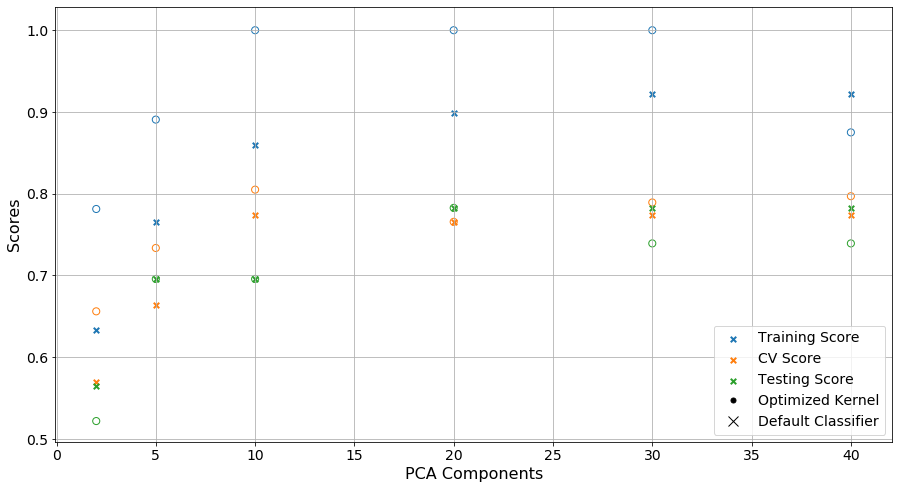

In [263]:
#SVM Kernel and Regularization Strength Optimization with gridsearch and PCA components

clf = KNeighborsClassifier()
params={'n_neighbors':[1,3,5,7,9,15,20],'weights':['uniform', 'distance'], 'p':[1,2]}
45

#kernel_dict = {'linear':0, 'poly':0, 'rbf':0, 'sigmoid':0}
#reg_strength_dict = {'0.5':0,'1':0,'3':0,'5':0,'7':0,'9':0}
#params={'C':10.**np.arange(0,2,0.4), 'class_weight':['None', 'balanced'],'kernel':['linear','poly', 'rbf', 'sigmoid'],\
#       'degree':[2,3,4,5], 'gamma':['auto', 'scaled']}
verbose=1 


pca_num  = np.array((2,5,10,20,30,40))
trainsize=0.85
rs = random_state


data = np.copy(waveform_data_ht)
y    = np.copy(y_numeric)
data_train, data_test, y_train, y_test = train_test_split(data, y, train_size=trainsize, test_size=1-trainsize, random_state=rs)

#Standardize the data before applying PCA
SS_data = StandardScaler()
data_train =  SS_data.fit_transform(data_train)
data_test = SS_data.transform(data_test)

plt.figure(figsize=(15,8))
#standardization_time = time.time() 

print("# PCA Comp    # Classes Predicted \t Train score \t CV score \t Test Score ")

for pca_comp in pca_num:

    #Apply PCA
    pca = PCA(svd_solver='full', n_components=pca_comp, random_state=random_state)
    data_train_pca = pca.fit_transform(data_train)
    data_test_pca= pca.transform(data_test)
    pca_time = time.time() 
    
    #Perform a grid search over given parameters
    param_grid=params 
    nprocs=-1
    search = GridSearchCV(clf, param_grid, cv=5, n_jobs=nprocs)

    #Compute the cross validation, training and test scores
    search.fit(data_train_pca, y_train)
    score_train = search.score(data_train_pca, y_train)
    cv_scores = cross_val_score(search, data_train_pca, y_train, cv=5)
    score_test = search.score(data_test_pca,y_test)
    clf_class_predictions = np.unique(search.predict(data_test_pca))

    print("Number of PCA components = {}, LR best parameters = {}".format(pca_comp, search.best_params_))
    #print("Classes predicted by Random Forest = {}".format(le.inverse_transform(clf_class_predictions)))

    print(" %d \t \t \t %d \t\t %.2g \t\t %.2g \t\t %.2g"%(pca_comp, np.size(np.unique(clf_class_predictions)), score_train, \
                                             cv_scores.mean(), score_test))
    
    if pca_comp==pca_num[0]:
        plt.scatter(pca_comp, score_train, facecolors='none', edgecolors='C0' , marker='o', s=50)
        plt.scatter(pca_comp, cv_scores.mean(), facecolors='none', edgecolors='C1', marker='o', s=50)
        plt.scatter(pca_comp, score_test, facecolors='none', edgecolors='C2', marker='o', s=50 )
    else:
        plt.scatter(pca_comp, score_train, marker='o', s=50, facecolors='none', edgecolors='C0' )
        plt.scatter(pca_comp, cv_scores.mean(),marker='o', s=50,facecolors='none', edgecolors='C1'  )
        plt.scatter(pca_comp, score_test, marker='o', s=50,facecolors='none', edgecolors='C2' )
        
train_plot = plt.scatter(knn_rawscores_dict['pca'], knn_rawscores_dict['train_score'], marker='x', s=30, c='C0', label='Training Score')
cv_plot = plt.scatter(knn_rawscores_dict['pca'], knn_rawscores_dict['cv_score'], marker='x', s=30, c='C1',label='CV Score')
test_plot = plt.scatter(knn_rawscores_dict['pca'], knn_rawscores_dict['test_score'], marker='x', s=30, c='C2', label='Testing Score')

opt_params = mlines.Line2D([], [], color='k', marker='.', linestyle='None',
                          markersize=10, label='Optimized Kernel')
def_params = mlines.Line2D([], [], color='k', marker='x', linestyle='None',
                          markersize=10, label='Default Classifier')


plt.xlabel('PCA Components')
plt.ylabel('Scores')
plt.legend(handles = [train_plot, cv_plot, test_plot, opt_params, def_params])
plt.show()
plt.close()
   

# PCA Comp    # Classes Predicted 	 Train score 	 CV score 	 Test Score 
 2 	 	 	 3 		 0.78 		 0.69 		 0.52


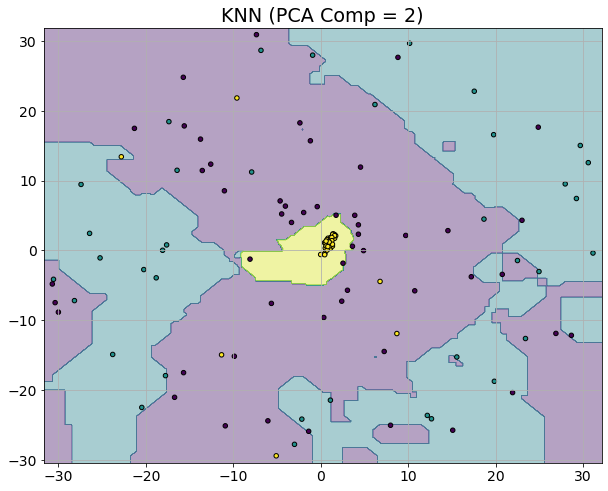

In [267]:
#Default KNN classifier

#Finding optimal training data size    
n  = 0.85
pca_num  = 2
#rf_orig = ml_classifier(clf, params, waveform_data_ht, y_numeric, n, pca_num, random_state, plot_decisiontree=False, verbose=0,parallelize=False)

#Split data into training and testing
data = np.copy(waveform_data_ht)
y    = np.copy(y_numeric)
data_train, data_test, y_train, y_test = train_test_split(data, y, train_size=trainsize, test_size=1-trainsize, random_state=rs)

#Standardize the data before applying PCA
SS_data = StandardScaler()
data_train =  SS_data.fit_transform(data_train)
data_test = SS_data.transform(data_test)

#Apply PCA
print("# PCA Comp    # Classes Predicted \t Train score \t CV score \t Test Score ")

pca = PCA(svd_solver='full', n_components=pca_num, random_state=random_state)
data_train_pca = pca.fit_transform(data_train)
data_test_pca= pca.transform(data_test)
pca_time = time.time() 

#SVM with default parameters
clf = KNeighborsClassifier(n_neighbors= 5, p=1, weights='uniform')
clf.fit(data_train_pca, y_train)

#Compute the cross validation, training and test scores
knn_train_score = clf.score(data_train_pca, y_train)
knn_cv_score = (cross_val_score(clf, data_train_pca, y_train, cv=5)).mean()
knn_test_score = clf.score(data_test_pca,y_test)
clf_class_predictions = np.unique(clf.predict(data_test_pca))


print(" %d \t \t \t %d \t\t %.2g \t\t %.2g \t\t %.2g"%(pca_num , np.size(np.unique(clf_class_predictions)), knn_train_score, \
                                         knn_cv_score, knn_test_score))

#print("Classes predicted by Random Forest = {}".format(le.inverse_transform(clf_class_predictions)))
#print("SVM with default settings and {%d} PCA components - "%pca_comp)
#print("\t Training Score = {:.4g}".format(svm_train_score[i]))
#print("\t CV Score       = {:.4g}".format(svm_cv_score[i]))
#print("\t Test Score = {:.4g}".format(svm_test_score[i]))


# Plotting decision regions

pca1_min, pca1_max = data_train_pca[:, 0].min() - 1, data_train_pca[:, 0].max() + 1
pca2_min, pca2_max = data_train_pca[:, 1].min() - 1, data_train_pca[:, 1].max() + 1

pca1_mesh, pca2_mesh = np.meshgrid(np.arange(pca1_min, pca1_max, 0.1),
                     np.arange(pca2_min, pca2_max, 0.1))

Z = clf.predict(np.c_[pca1_mesh.ravel(), pca2_mesh.ravel()])
Z = Z.reshape(pca1_mesh.shape)


f, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10, 8))

ax.contourf(pca1_mesh, pca2_mesh, Z, alpha=0.4)
ax.scatter(data_train_pca[:, 0], data_train_pca[:, 1], c=y_train, s=20, edgecolor='k')
ax.set_title('KNN (PCA Comp = 2)')
        
plt.show()
                                             
                          


In [268]:
#Try angular distance
from sklearn.metrics.pairwise import cosine_distances
#Default KNN classifier

#Finding optimal training data size    
n  = 0.85
pca_num  = 2
#rf_orig = ml_classifier(clf, params, waveform_data_ht, y_numeric, n, pca_num, random_state, plot_decisiontree=False, verbose=0,parallelize=False)

#Split data into training and testing
data = np.copy(waveform_data_ht)
y    = np.copy(y_numeric)
data_train, data_test, y_train, y_test = train_test_split(data, y, train_size=trainsize, test_size=1-trainsize, random_state=rs)

#Standardize the data before applying PCA
SS_data = StandardScaler()
data_train =  SS_data.fit_transform(data_train)
data_test = SS_data.transform(data_test)

#Apply PCA
print("# PCA Comp    # Classes Predicted \t Train score \t CV score \t Test Score ")

pca = PCA(svd_solver='full', n_components=pca_num, random_state=random_state)
data_train_pca = pca.fit_transform(data_train)
data_test_pca= pca.transform(data_test)
pca_time = time.time() 

#SVM with default parameters
clf = KNeighborsClassifier(n_neighbors= 5, p=1, weights='uniform', metric=cosine_distances)
clf.fit(data_train_pca, y_train)

#Compute the cross validation, training and test scores
knn_train_score = clf.score(data_train_pca, y_train)
knn_cv_score = (cross_val_score(clf, data_train_pca, y_train, cv=5)).mean()
knn_test_score = clf.score(data_test_pca,y_test)
clf_class_predictions = np.unique(clf.predict(data_test_pca))


print(" %d \t \t \t %d \t\t %.2g \t\t %.2g \t\t %.2g"%(pca_num , np.size(np.unique(clf_class_predictions)), knn_train_score, \
                                         knn_cv_score, knn_test_score))

#print("Classes predicted by Random Forest = {}".format(le.inverse_transform(clf_class_predictions)))
#print("SVM with default settings and {%d} PCA components - "%pca_comp)
#print("\t Training Score = {:.4g}".format(svm_train_score[i]))
#print("\t CV Score       = {:.4g}".format(svm_cv_score[i]))
#print("\t Test Score = {:.4g}".format(svm_test_score[i]))


# Plotting decision regions

pca1_min, pca1_max = data_train_pca[:, 0].min() - 1, data_train_pca[:, 0].max() + 1
pca2_min, pca2_max = data_train_pca[:, 1].min() - 1, data_train_pca[:, 1].max() + 1

pca1_mesh, pca2_mesh = np.meshgrid(np.arange(pca1_min, pca1_max, 0.1),
                     np.arange(pca2_min, pca2_max, 0.1))

Z = clf.predict(np.c_[pca1_mesh.ravel(), pca2_mesh.ravel()])
Z = Z.reshape(pca1_mesh.shape)


f, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10, 8))

ax.contourf(pca1_mesh, pca2_mesh, Z, alpha=0.4)
ax.scatter(data_train_pca[:, 0], data_train_pca[:, 1], c=y_train, s=20, edgecolor='k')
ax.set_title('KNN (PCA Comp = 2)')
        
plt.show()
                                             
                          


# PCA Comp    # Classes Predicted 	 Train score 	 CV score 	 Test Score 


ValueError: Expected 2D array, got 1D array instead:
array=[-2.77555756e-16  2.35922393e-16].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.